In this notebook, I demonstrate how to distinguish between structured and random signals 
by means of computing different kinds of entropies as a complexity measure.

### Installation & service

In [1]:
# !pip install antropy EntropyHub ipython-autotime nb_black

In [1]:
%load_ext autoreload
%load_ext autotime
%load_ext nb_black
%autoreload 2

time: 141 ms (started: 2023-04-09 08:09:16 +03:00)


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

time: 0 ns (started: 2023-04-09 08:09:16 +03:00)


<IPython.core.display.Javascript object>

### Imports & code definitions

In [122]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from functools import wraps
import EntropyHub as EH
import antropy as ant
import warnings


def naive_entropy(x):
    "Naive Shannon entropy implementation"
    vals, counts = np.unique(
        x,
        return_counts=True,
    )

    return entropy(counts)


def alter_series(series: dict, name: str):
    "Adds noisy and shuffled options of the series"
    series["noisy_" + name] = series[name] + (np.random.random(N) - 0.5) / 4
    series["shuffled_" + name] = series[name].copy()
    np.random.shuffle(series["shuffled_" + name])


def create_samples() -> tuple:
    "Create a structured, a noisy, a random, and a structured but randomly shuffled 1D arrays"

    series = {}
    series["constant"] = np.ones(N)
    series["line"] = np.arange(N) * 0.01 - 0.4
    alter_series(series, "line")

    series["parabola"] = np.arange(N) ** 2 / 200
    alter_series(series, "parabola")

    series["sine"] = np.sin(np.arange(N))
    alter_series(series, "sine")

    series["random_uniform"] = np.random.uniform(size=N)
    series["random_normal"] = np.random.normal(size=N)
    series["random_lognormal"] = np.random.lognormal(size=N)

    plt.figure(figsize=(10, 5))
    for var_name, var_data in series.items():
        if "random" in var_name:
            linestyle = "dotted"
            alpha = 0.6
        elif "shuffled" in var_name:
            continue
            linestyle = "dashdot"
            alpha = 0.3
        elif "nois" in var_name:
            linestyle = "dashed"
            alpha = 1
        else:
            alpha = 1
            linestyle = "solid"
        plt.plot(var_data, alpha=alpha, label=var_name, linestyle=linestyle)

    plt.xlim(0, N)
    plt.ylim(-2, 2)
    plt.legend()

    return series


def eh_wrapper(func: object) -> float:
    "We only need the last element of the sequence returned by EntropyHub."

    @wraps(func)
    def inner(*args):
        res = func(
            *args,
        )[0]
        try:
            res = res[-1]
        except:
            pass
        return res

    return inner

def compare_entropies():
    "Compute a set of entropies for each series & put results into a table."
    global df

    vals = []
    for arr_name, arr in series.items():
        row = {"series": arr_name}
        for func in (
            naive_entropy,
            *[getattr(ant, fn) for fn in antropy_functions],
            *[eh_wrapper(getattr(EH, fn)) for fn in EntropyHub_functions],
        ):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    row[func.__name__] = func(arr)
            except Exception as e:
                pass
        vals.append(row)
    df = pd.DataFrame(vals).set_index("series")
    return df.style.set_caption(f"Sample size:{N:_}")

time: 0 ns (started: 2023-04-09 09:35:30 +03:00)


<IPython.core.display.Javascript object>

In [129]:
antropy_functions = [fn for fn in dir(ant) if fn.endswith("_entropy")]
print(antropy_functions)

['app_entropy', 'perm_entropy', 'sample_entropy', 'spectral_entropy', 'svd_entropy']
time: 15 ms (started: 2023-04-09 09:52:47 +03:00)


<IPython.core.display.Javascript object>

In [130]:
EntropyHub_functions = [fn for fn in dir(EH) if fn.endswith("En") and "_" not in fn]
print(EntropyHub_functions)

['ApEn', 'AttnEn', 'BubbEn', 'CoSiEn', 'CondEn', 'DispEn', 'DistEn', 'EnofEn', 'FuzzEn', 'GridEn', 'IncrEn', 'K2En', 'MSEn', 'PermEn', 'PhasEn', 'SampEn', 'SlopEn', 'SpecEn', 'SyDyEn', 'XApEn', 'XCondEn', 'XDistEn', 'XFuzzEn', 'XK2En', 'XMSEn', 'XPermEn', 'XSampEn', 'XSpecEn', 'cMSEn', 'cXMSEn', 'hMSEn', 'hXMSEn', 'rMSEn', 'rXMSEn']
time: 0 ns (started: 2023-04-09 09:52:53 +03:00)


<IPython.core.display.Javascript object>

### Generating structured, noisy, random random, semi-structured short series

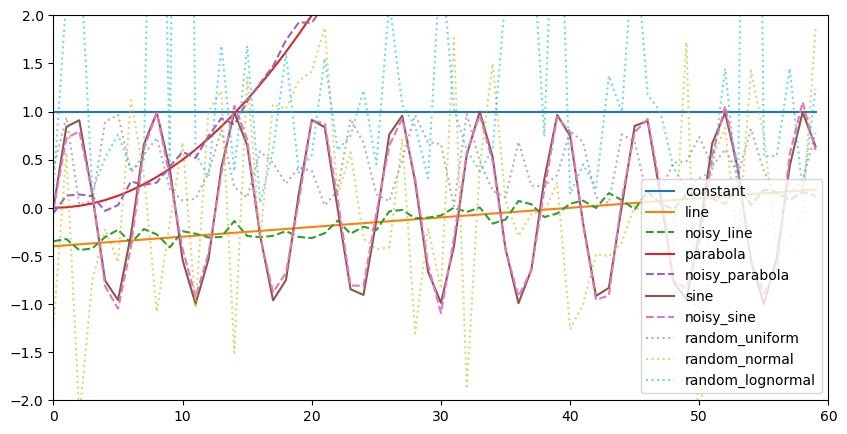

time: 234 ms (started: 2023-04-09 09:35:31 +03:00)


<IPython.core.display.Javascript object>

In [125]:
N = 60
series = create_samples()

### Comparing different entropies on all 3 short series

In [135]:
compare_entropies()

Note: 17/18 bins were empty


,naive_entropy,app_entropy,perm_entropy,sample_entropy,svd_entropy,ApEn,BubbEn,CoSiEn,DispEn,DistEn,EnofEn,FuzzEn,PermEn,SampEn,SlopEn,SpecEn,SyDyEn,CondEn,GridEn,K2En,AttnEn
series,,,,,,,,,,,,,,,,,,,,,
constant,0.000000,0.000000,-0.000000,nan,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.150000,-0.000000,nan,nan,nan,nan
line,6.214608,-0.001936,-0.000000,-0.000000,0.019142,-0.001936,0.000000,0.622037,1.105726,0.933922,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.227192,1.933111,0.054152,1.110851,0.217082,nan
noisy_line,6.214608,0.134217,2.570090,0.140383,0.245306,0.134217,0.492809,0.732579,1.257065,0.931364,1.377256,0.039587,0.996843,0.140383,1.456481,0.228083,3.059020,0.368612,1.277909,0.299416,1.508512
shuffled_line,6.214608,1.452726,2.581884,2.172833,1.403645,1.452726,0.530243,0.888418,2.158741,0.955791,2.051137,1.800431,0.999510,2.172833,2.017510,0.422229,3.682426,1.755407,2.193985,2.559241,1.589341
parabola,6.214608,0.000973,-0.000000,0.005547,0.011994,0.000973,0.000000,0.092803,1.084804,0.939693,0.662348,0.644633,-0.000000,0.005547,0.810198,0.275281,1.933111,0.053525,0.970817,0.169892,nan
noisy_parabola,6.214608,0.000973,0.079493,0.005547,0.013187,0.000973,0.003714,0.118206,1.084804,0.939665,0.662348,0.738298,0.053004,0.005547,0.835748,0.275282,1.933111,0.053525,0.970817,0.169682,0.000000
shuffled_parabola,6.214608,1.486568,2.584543,1.923524,1.482648,1.486568,0.532473,0.903167,2.117975,0.980830,2.515681,11.887310,0.999974,1.923524,1.033675,0.516613,3.675054,1.592207,1.938746,2.107027,1.557964
sine,6.214608,0.116555,2.222109,0.139154,0.999393,0.116555,0.519155,0.516570,1.939356,0.994375,1.684428,0.784866,0.999997,0.139154,1.267799,0.250069,2.078092,1.144282,1.943179,0.296499,0.718541
noisy_sine,6.214608,0.444432,2.222620,0.465315,1.201244,0.444432,0.519155,0.516570,1.934944,0.979597,1.623218,0.800534,0.999997,0.465315,1.604855,0.263703,2.625438,1.192389,1.935658,0.782657,0.832287


time: 3.03 s (started: 2023-04-09 10:17:49 +03:00)


<IPython.core.display.Javascript object>

### Finding the most discriminating entropies

In [156]:
noisy = df.query('series.str.contains("noisy")')
noisy.index = noisy.index.str.replace("noisy_", "")

shuffled = df.query('series.str.contains("shuffled")')
shuffled.index = shuffled.index.str.replace("shuffled_", "")


rnd = df.query('series.str.contains("random")')
rnd.index = shuffled.index.str.replace("random_", "")

normal = df[df.index.isin(["line", "parabola", "sine"])]

time: 16 ms (started: 2023-04-09 10:29:28 +03:00)


<IPython.core.display.Javascript object>

In [162]:
(
    normal.div(noisy).mean(axis=0)
    + normal.div(shuffled).mean(axis=0)
    + normal.div(rnd).mean(axis=0)
    + noisy.div(shuffled).mean(axis=0)
    + noisy.div(rnd).mean(axis=0)
    + shuffled.div(rnd).mean(axis=0)
).sort_values().head(6)

sample_entropy    1.786956
SampEn            1.786956
app_entropy       1.807307
ApEn              1.807307
K2En              2.309500
svd_entropy       2.698288
dtype: float64

time: 16 ms (started: 2023-04-09 10:38:33 +03:00)


<IPython.core.display.Javascript object>

In [160]:
df[["SampEn", "ApEn", "K2En", "svd_entropy"]]

,SampEn,ApEn,K2En,svd_entropy
series,,,,
constant,-0.000000,0.000000,NaN,6.397546e-14
line,-0.000000,-0.001936,0.217082,1.914237e-02
noisy_line,0.140383,0.134217,0.299416,2.453059e-01
shuffled_line,2.172833,1.452726,2.559241,1.403645e+00
parabola,0.005547,0.000973,0.169892,1.199400e-02
noisy_parabola,0.005547,0.000973,0.169682,1.318723e-02
shuffled_parabola,1.923524,1.486568,2.107027,1.482648e+00
sine,0.139154,0.116555,0.296499,9.993926e-01
noisy_sine,0.465315,0.444432,0.782657,1.201244e+00


time: 16 ms (started: 2023-04-09 10:33:33 +03:00)


<IPython.core.display.Javascript object>

### What about longer series?

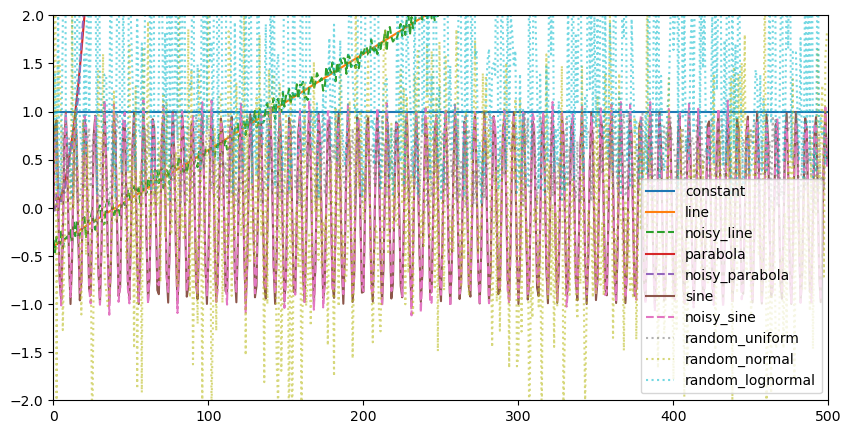

time: 296 ms (started: 2023-04-09 10:43:20 +03:00)


<IPython.core.display.Javascript object>

In [163]:
N = 500
series = create_samples()

In [164]:
compare_entropies()

Note: 17/18 bins were empty


,naive_entropy,app_entropy,perm_entropy,sample_entropy,svd_entropy,ApEn,BubbEn,CoSiEn,DispEn,DistEn,EnofEn,FuzzEn,PermEn,SampEn,SlopEn,SpecEn,SyDyEn,CondEn,GridEn,K2En,AttnEn
series,,,,,,,,,,,,,,,,,,,,,
constant,0.000000,0.000000,-0.000000,nan,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.150000,-0.000000,nan,nan,nan,nan
line,6.214608,-0.001936,-0.000000,-0.000000,0.019142,-0.001936,0.000000,0.622037,1.105726,0.933922,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.227192,1.933111,0.054152,1.110851,0.217082,nan
noisy_line,6.214608,0.127011,2.549473,0.131229,0.238294,0.127011,0.481731,0.676699,1.255416,0.932310,1.261571,0.037160,0.993591,0.131229,1.458114,0.227553,2.887870,0.336966,1.264003,0.303313,1.473092
shuffled_line,6.214608,1.450810,2.572828,2.202835,1.415794,1.450810,0.498229,0.888922,2.155866,0.955470,2.007053,1.794200,0.998954,2.202835,2.045524,0.425458,3.673359,1.773227,2.189540,2.602195,1.527445
parabola,6.214608,0.000973,-0.000000,0.005547,0.011994,0.000973,0.000000,0.092803,1.084804,0.939693,0.662348,0.644633,-0.000000,0.005547,0.810198,0.275281,1.933111,0.053525,0.970817,0.169892,nan
noisy_parabola,6.214608,0.000973,0.190047,0.005547,0.013156,0.000973,0.018449,0.141304,1.084804,0.939639,0.662348,0.736239,0.093931,0.005547,0.808552,0.275283,1.933111,0.053525,0.970817,0.170198,1.060475
shuffled_parabola,6.214608,1.434248,2.577236,1.818692,1.483130,1.434248,0.515537,0.908291,2.119467,0.981077,2.403818,38.535624,0.999928,1.818692,1.037613,0.520101,3.695978,1.576473,1.935524,2.111579,1.574883
sine,6.214608,0.116555,2.222109,0.139154,0.999393,0.116555,0.519155,0.516570,1.939356,0.994375,1.684428,0.784866,0.999997,0.139154,1.267799,0.250069,2.078092,1.144282,1.943179,0.296499,0.718541
noisy_sine,6.214608,0.422842,2.220797,0.442672,1.204089,0.422842,0.519155,0.513918,1.942200,0.978327,1.824016,0.802129,0.999997,0.442672,1.601624,0.262560,3.205578,1.198380,1.939405,0.751059,0.719024


time: 3.08 s (started: 2023-04-09 10:43:23 +03:00)


<IPython.core.display.Javascript object>

### Performance benchmarks

In [171]:
%timeit ant.sample_entropy(series['sine'])

817 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time: 6.64 s (started: 2023-04-09 10:52:33 +03:00)


<IPython.core.display.Javascript object>

In [172]:
%timeit eh_wrapper(EH.SampEn)(series['sine'])

52.3 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
time: 4.27 s (started: 2023-04-09 10:52:39 +03:00)


<IPython.core.display.Javascript object>